# MSc Project : Extending to lat-lon

### Using 2019 Monsoon season (JJAS) - Temp (at 2m) and Precipitaion (TRMM/GPM data) to find a relation b/w ERRs and maximum temperature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import netCDF4
import pandas as pd
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
from dask.distributed import Client, Variable
%matplotlib inline

In [2]:
from functions import ccplot, binning

In [3]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
plt.style.use('seaborn-pastel')
sns.set_theme(style="ticks")

In [4]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu_r', cmap_sequential='Greens')

In [22]:
# ds_comb.to_netcdf('./data/combined/ds_comb.nc')
ds_comb = xr.open_dataset('./data/combined/ds_comb.nc')

In [23]:
ds_comb

<xarray.Dataset>
Dimensions:           (lon: 181, lat: 141, time: 2928)
Coordinates:
  * lon               (lon) float64 50.0 50.25 50.5 50.75 ... 94.5 94.75 95.0
  * lat               (lat) float64 5.0 5.25 5.5 5.75 ... 39.25 39.5 39.75 40.0
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipitationCal  (time, lat, lon) float32 ...
    t2m               (time, lat, lon) float32 ...
    d2m               (time, lat, lon) float32 ...

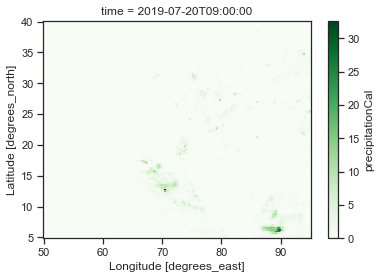

In [24]:
ds_comb.precipitationCal.sel(time = "2019-07-20 09:00:00").plot()

In [25]:
precip = ds_comb.precipitationCal
t2m = ds_comb.t2m
d2m = ds_comb.d2m

In [26]:
precip

<xarray.DataArray 'precipitationCal' (time: 2928, lat: 141, lon: 181)>
[74725488 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 50.0 50.25 50.5 50.75 51.0 ... 94.25 94.5 94.75 95.0
  * lat      (lat) float64 5.0 5.25 5.5 5.75 6.0 ... 39.0 39.25 39.5 39.75 40.0
  * time     (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00

In [27]:
precip_daily_rate = precip[::-1].rolling(time=24).sum()[::-1]

In [28]:
precip_daily_rate

<xarray.DataArray 'precipitationCal' (time: 2928, lat: 141, lon: 181)>
array([[[           nan,  3.7997961e-07, -1.8981518e-07, ...,
          2.4799250e+01,  3.2316833e+01,  1.5889658e+01],
        [           nan,  3.9415088e-04,  2.1894810e-04, ...,
          1.2490607e+01,  1.1476955e+01,  1.2582856e+00],
        [           nan,  3.8946441e-03,  4.3784198e-04, ...,
          9.1446304e+00,  6.8441048e+00,  3.4000895e+00],
        ...,
        [           nan,  5.3644180e-07, -7.3760748e-07, ...,
          1.5366822e-06,  2.7817441e-07,  2.6724010e-06],
        [           nan, -1.9438739e-06, -4.4126064e-06, ...,
          6.3913879e-03,  7.0780516e-07,  1.8260011e-03],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,  3.7997961e-07, -1.8981518e-07, ...,
          2.6646700e+01,  3.3714130e+01,  1.6155140e+01],
        [           nan,  3.9415088e-04,  2.1894810e-04, ...,
          1.4253363e+01,  1.2703703e+01,  1.3647047e+00],
        [           nan,  3.8946441e-03,  4.3784198e-04, ...,
          9.9490986e+00,  7.3083048e+00,  3.4065528e+00],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 50.0 50.25 50.5 50.75 51.0 ... 94.25 94.5 94.75 95.0
  * lat      (lat) float64 5.0 5.25 5.5 5.75 6.0 ... 39.0 39.25 39.5 39.75 40.0
  * time     (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00

In [29]:
## We need to get the precipitation in mm/day from mm/hour

In [30]:
# Set values less than 1 mm/hr to nan

precip = xr.where(precip_daily_rate < 0.3, np.nan, precip)
t2m = t2m.where(precip_daily_rate != np.nan)
d2m = d2m.where(precip_daily_rate != np.nan)

# precip = xr.where(precip < 1, np.nan, precip)
# t2m = t2m.where(precip != np.nan)
# d2m = d2m.where(precip != np.nan)

In [32]:
ds_comb = xr.merge([precip, t2m, d2m]).chunk(dict(time=-1))
ds_comb

<xarray.Dataset>
Dimensions:           (lon: 181, lat: 141, time: 2928)
Coordinates:
  * lon               (lon) float64 50.0 50.25 50.5 50.75 ... 94.5 94.75 95.0
  * lat               (lat) float64 5.0 5.25 5.5 5.75 ... 39.25 39.5 39.75 40.0
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipitationCal  (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    t2m               (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    d2m               (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>

In [33]:
# client = Client()

## Plots for small domain

In [34]:
ccscale99_t2m_slope, ccscale99_t2m_p = binning.get_binned_3d(ds_comb.sel(lat = slice(17,22), lon = slice(70,75)), percentile_val=0.99, var = "t2m", var_bin="t2m_bins", bin_nr=12)

In [55]:
ccscale99_d2m_slope, ccscale99_d2m_p = binning.get_binned_3d(ds_comb.sel(lat = slice(17,22), lon = slice(70,75)), percentile_val=0.99, var = "d2m", var_bin="d2m_bins", bin_nr=12)

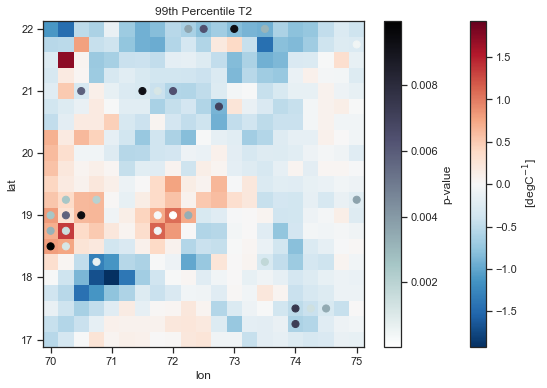

In [53]:
# lat = ccscale99_t2m.coords['lat']
# lon = ccscale99_t2m.coords['lon']

# fig = plt.figure(figsize=(9, 6))
# ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
# ax.set_extent([70, 75, 17, 22], crs=ccrs.Mercator())

ccscale99_t2m_slope.plot(size=6)
# xr.plot.imshow(ccscale99_t2m_slope)
x, y = np.meshgrid(ccscale99_t2m_slope.coords['lon'], ccscale99_t2m_slope.coords['lat'])
plt.scatter(x,y, c = ccscale99_t2m_p.where(ccscale99_t2m_p < 0.01).to_numpy(), cmap = "bone_r", marker='o', s=50)
plt.colorbar(label = "p-value", location = "right")

# plt.contourf(lon, lat, ccscale99_t2m, transform = ccrs.Mercator())
# ax.coastlines()
# gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
# gridliner.top_labels = False
# gridliner.bottom_labels = True
# gridliner.left_labels = True
# gridliner.right_labels = False
# gridliner.ylines = False  # you need False
# gridliner.xlines = False  # you need False
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS)

plt.title('99th Percentile T2')

plt.savefig('./images/ccscale99_t2m.pdf', dpi=300)

# fig.tight_layout()

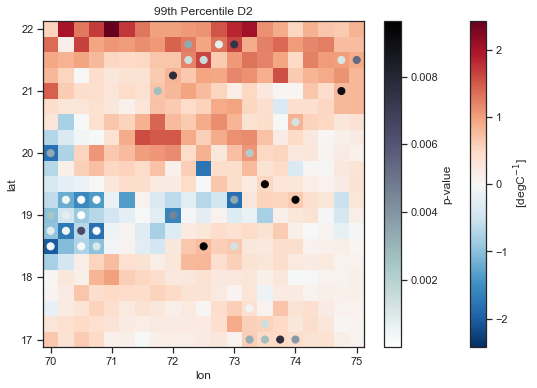

In [56]:
# fig, ax = plt.figure(figsize=(20, 15))
# ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
# ax.set_extent([68, 70, 12, 14], crs=ccrs.Mercator())
# fig = plt.figure(figsize=(9, 6))
ccscale99_d2m_slope.plot(size=6)
# xr.plot.contourf(ccscale99_d2m_slope)
x, y = np.meshgrid(ccscale99_d2m_slope.coords['lon'], ccscale99_d2m_slope.coords['lat'])
plt.scatter(x,y, c = ccscale99_d2m_p.where(ccscale99_d2m_p < 0.01).to_numpy(), cmap = "bone_r", marker='o', s=50)
plt.colorbar(label = "p-value", location = "right")
# gridliner = ax.gridlines(crs=ccrs.Mercator())
# gridliner.top_labels = False
# gridliner.bottom_labels = True
# gridliner.left_labels = True
# gridliner.right_labels = False
# gridliner.ylines = False  # you need False
# gridliner.xlines = False  # you need False
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS)

plt.title('99th Percentile D2')

plt.savefig('./images/ccscale99_d2m.pdf', dpi=300)

# fig.tight_layout()

In [284]:
ccscale50_t2m_slope, ccscale50_t2m_p = binning.get_binned_3d(ds_comb.sel(lat = slice(17,22), lon = slice(70,75)), percentile_val=0.50, var = "t2m", var_bin="t2m_bins", bin_nr=12)

In [285]:
ccscale50_d2m_slope, ccscale50_d2m_p = binning.get_binned_3d(ds_comb.sel(lat = slice(17,22), lon = slice(70,75)), percentile_val=0.50, var = "d2m", var_bin="d2m_bins", bin_nr=12)

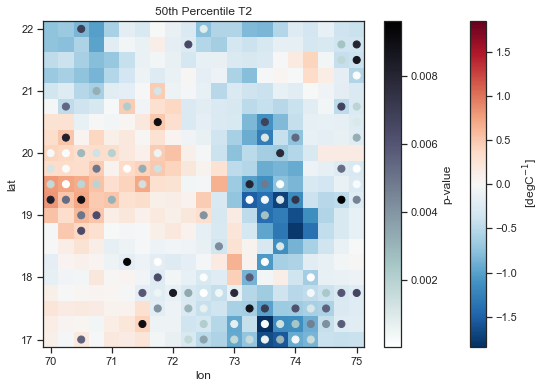

In [286]:
# fig, ax = plt.figure(figsize=(20, 15))
# ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
# ax.set_extent([68, 70, 12, 14], crs=ccrs.Mercator())
fig = plt.figure(figsize=(9, 6))
ccscale50_t2m_slope.plot()
# xr.plot.contourf(ccscale50_t2m_slope)
x, y = np.meshgrid(ccscale50_t2m_slope.coords['lon'], ccscale50_t2m_slope.coords['lat'])
plt.scatter(x,y, c = ccscale50_t2m_p.where(ccscale50_t2m_p < 0.01).to_numpy(), cmap = "bone_r", marker='o', s=50)
plt.colorbar(label = "p-value", location = "right")
# gridliner = ax.gridlines(crs=ccrs.Mercator())
# gridliner.top_labels = False
# gridliner.bottom_labels = True
# gridliner.left_labels = True
# gridliner.right_labels = False
# gridliner.ylines = False  # you need False
# gridliner.xlines = False  # you need False
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS)

plt.title('50th Percentile T2')

plt.savefig('./images/ccscale50_t2m.pdf', dpi=300)

# fig.tight_layout()

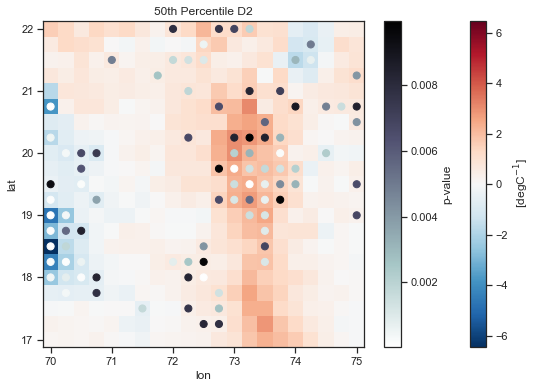

In [289]:
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
# ax.set_extent([70, 75, 17, 22], crs=ccrs.Mercator())
fig = plt.figure(figsize=(9, 6))
ccscale50_d2m_slope.plot()
# xr.plot.contourf(ccscale50_d2m_slope)
x, y = np.meshgrid(ccscale50_d2m_slope.coords['lon'], ccscale50_d2m_slope.coords['lat'])
plt.scatter(x,y, c = ccscale50_d2m_p.where(ccscale50_d2m_p < 0.01).to_numpy(), cmap = "bone_r", marker='o', s=50)
plt.colorbar(label = "p-value", location = "right")
# gridliner = ax.gridlines(crs=ccrs.Mercator())
# gridliner.top_labels = False
# gridliner.bottom_labels = True
# gridliner.left_labels = True
# gridliner.right_labels = False
# gridliner.ylines = False  # you need False
# gridliner.xlines = False  # you need False
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS)

plt.title('50th Percentile D2')

plt.savefig('./images/ccscale50_d2m.pdf', dpi=300)

# fig.tight_layout()

## Plotting for India

In [57]:
ccscale99_t2m_slope, ccscale99_t2m_p = binning.get_binned_3d(ds_comb, percentile_val=0.99, var = "t2m", var_bin="t2m_bins", bin_nr=12)

/home/aditya/.miniconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/aditya/.miniconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/aditya/.miniconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/aditya/.miniconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/aditya/.miniconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/aditya/.miniconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/aditya/.miniconda/lib/python3.8/site-pac

KeyboardInterrupt: 

In [282]:
ccscale99_d2m_slope, ccscale99_d2m_p = binning.get_binned_3d(ds_comb, percentile_val=0.99, var = "d2m", var_bin="d2m_bins", bin_nr=12)

Text(0.5, 1.0, '99th Percentile T2')

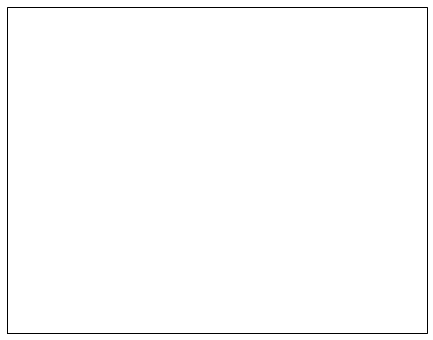

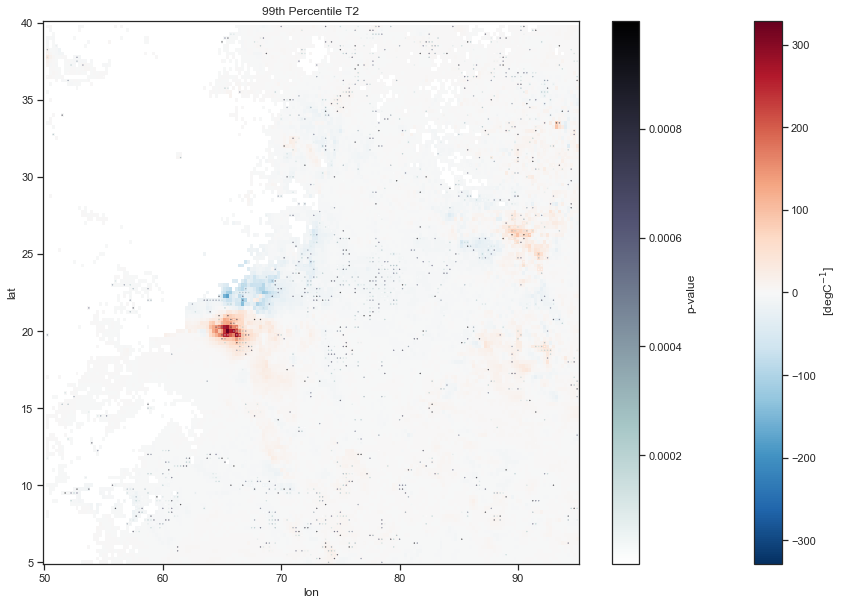

In [58]:
# lat = ccscale99_t2m.coords['lat']
# lon = ccscale99_t2m.coords['lon']

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.set_extent([50, 95, 5, 40], crs=ccrs.Mercator())

ccscale99_t2m_slope.plot(size=10)
# xr.plot.contourf(ccscale99_t2m_slope)
x, y = np.meshgrid(ccscale99_t2m_slope.coords['lon'], ccscale99_t2m_slope.coords['lat'])
plt.scatter(x,y, c = ccscale99_t2m_p.where(ccscale99_t2m_p < 0.001).to_numpy(), cmap = "bone_r", marker='o', s=0.1)
plt.colorbar(label = "p-value", location = "right")

# plt.contourf(lon, lat, ccscale99_t2m, transform = ccrs.Mercator())
ax.coastlines()
# gridliner = ax.gridlines(crs=ccrs.Mercator())
# gridliner.top_labels = False
# gridliner.bottom_labels = True
# gridliner.left_labels = True
# gridliner.right_labels = False
# gridliner.ylines = False  # you need False
# gridliner.xlines = False  # you need False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

plt.title('99th Percentile T2')

# plt.savefig('./images/ccscale99_t2m.pdf', dpi=300)

# fig.tight_layout()